In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk',
    palette='Set1'
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score



[![scikit-learn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)](http://scikit-learn.org/)

*Scikit-learn* is a Python package for **machine learning**:


- Simple and efficient tools for data mining and data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license

We will do [one of the many tutorials](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) from the *scikit-learn* website. 

You can install *scikit-learn* with `conda install scikit-learn`.

## Supervised learning: predicting an output variable from high-dimensional observations

Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. Most often, `y` is a 1D array of length `n_samples`.

All supervised estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

## Possum dataset

The [Possum dataset](https://www.kaggle.com/datasets/abrambeyer/openintro-possum) comprises nine morphometric measurements for each of the 104 mountain brushtail possums captured at seven locations spanning from Southern Victoria to central Queensland.  

<img src="https://storage.googleapis.com/kaggle-datasets-images/1534513/2532158/c49c3c89019ed2251376ecfcf7a7eec0/dataset-cover.jpg?t=2021-08-17-01-33-40" width="200"/>

Let's start by loading the dataset.

In [2]:
filename = '../data/possum.csv'
possum_data = pd.read_csv(filename)
possum_data.head()


,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


## Goal

We aim to build a model that predicts the **chest size** ('chest') based on the rest of features within the dataset.

## Basic data visualization and preprocessing

Data visualization is an important step before applying machine-learning models.



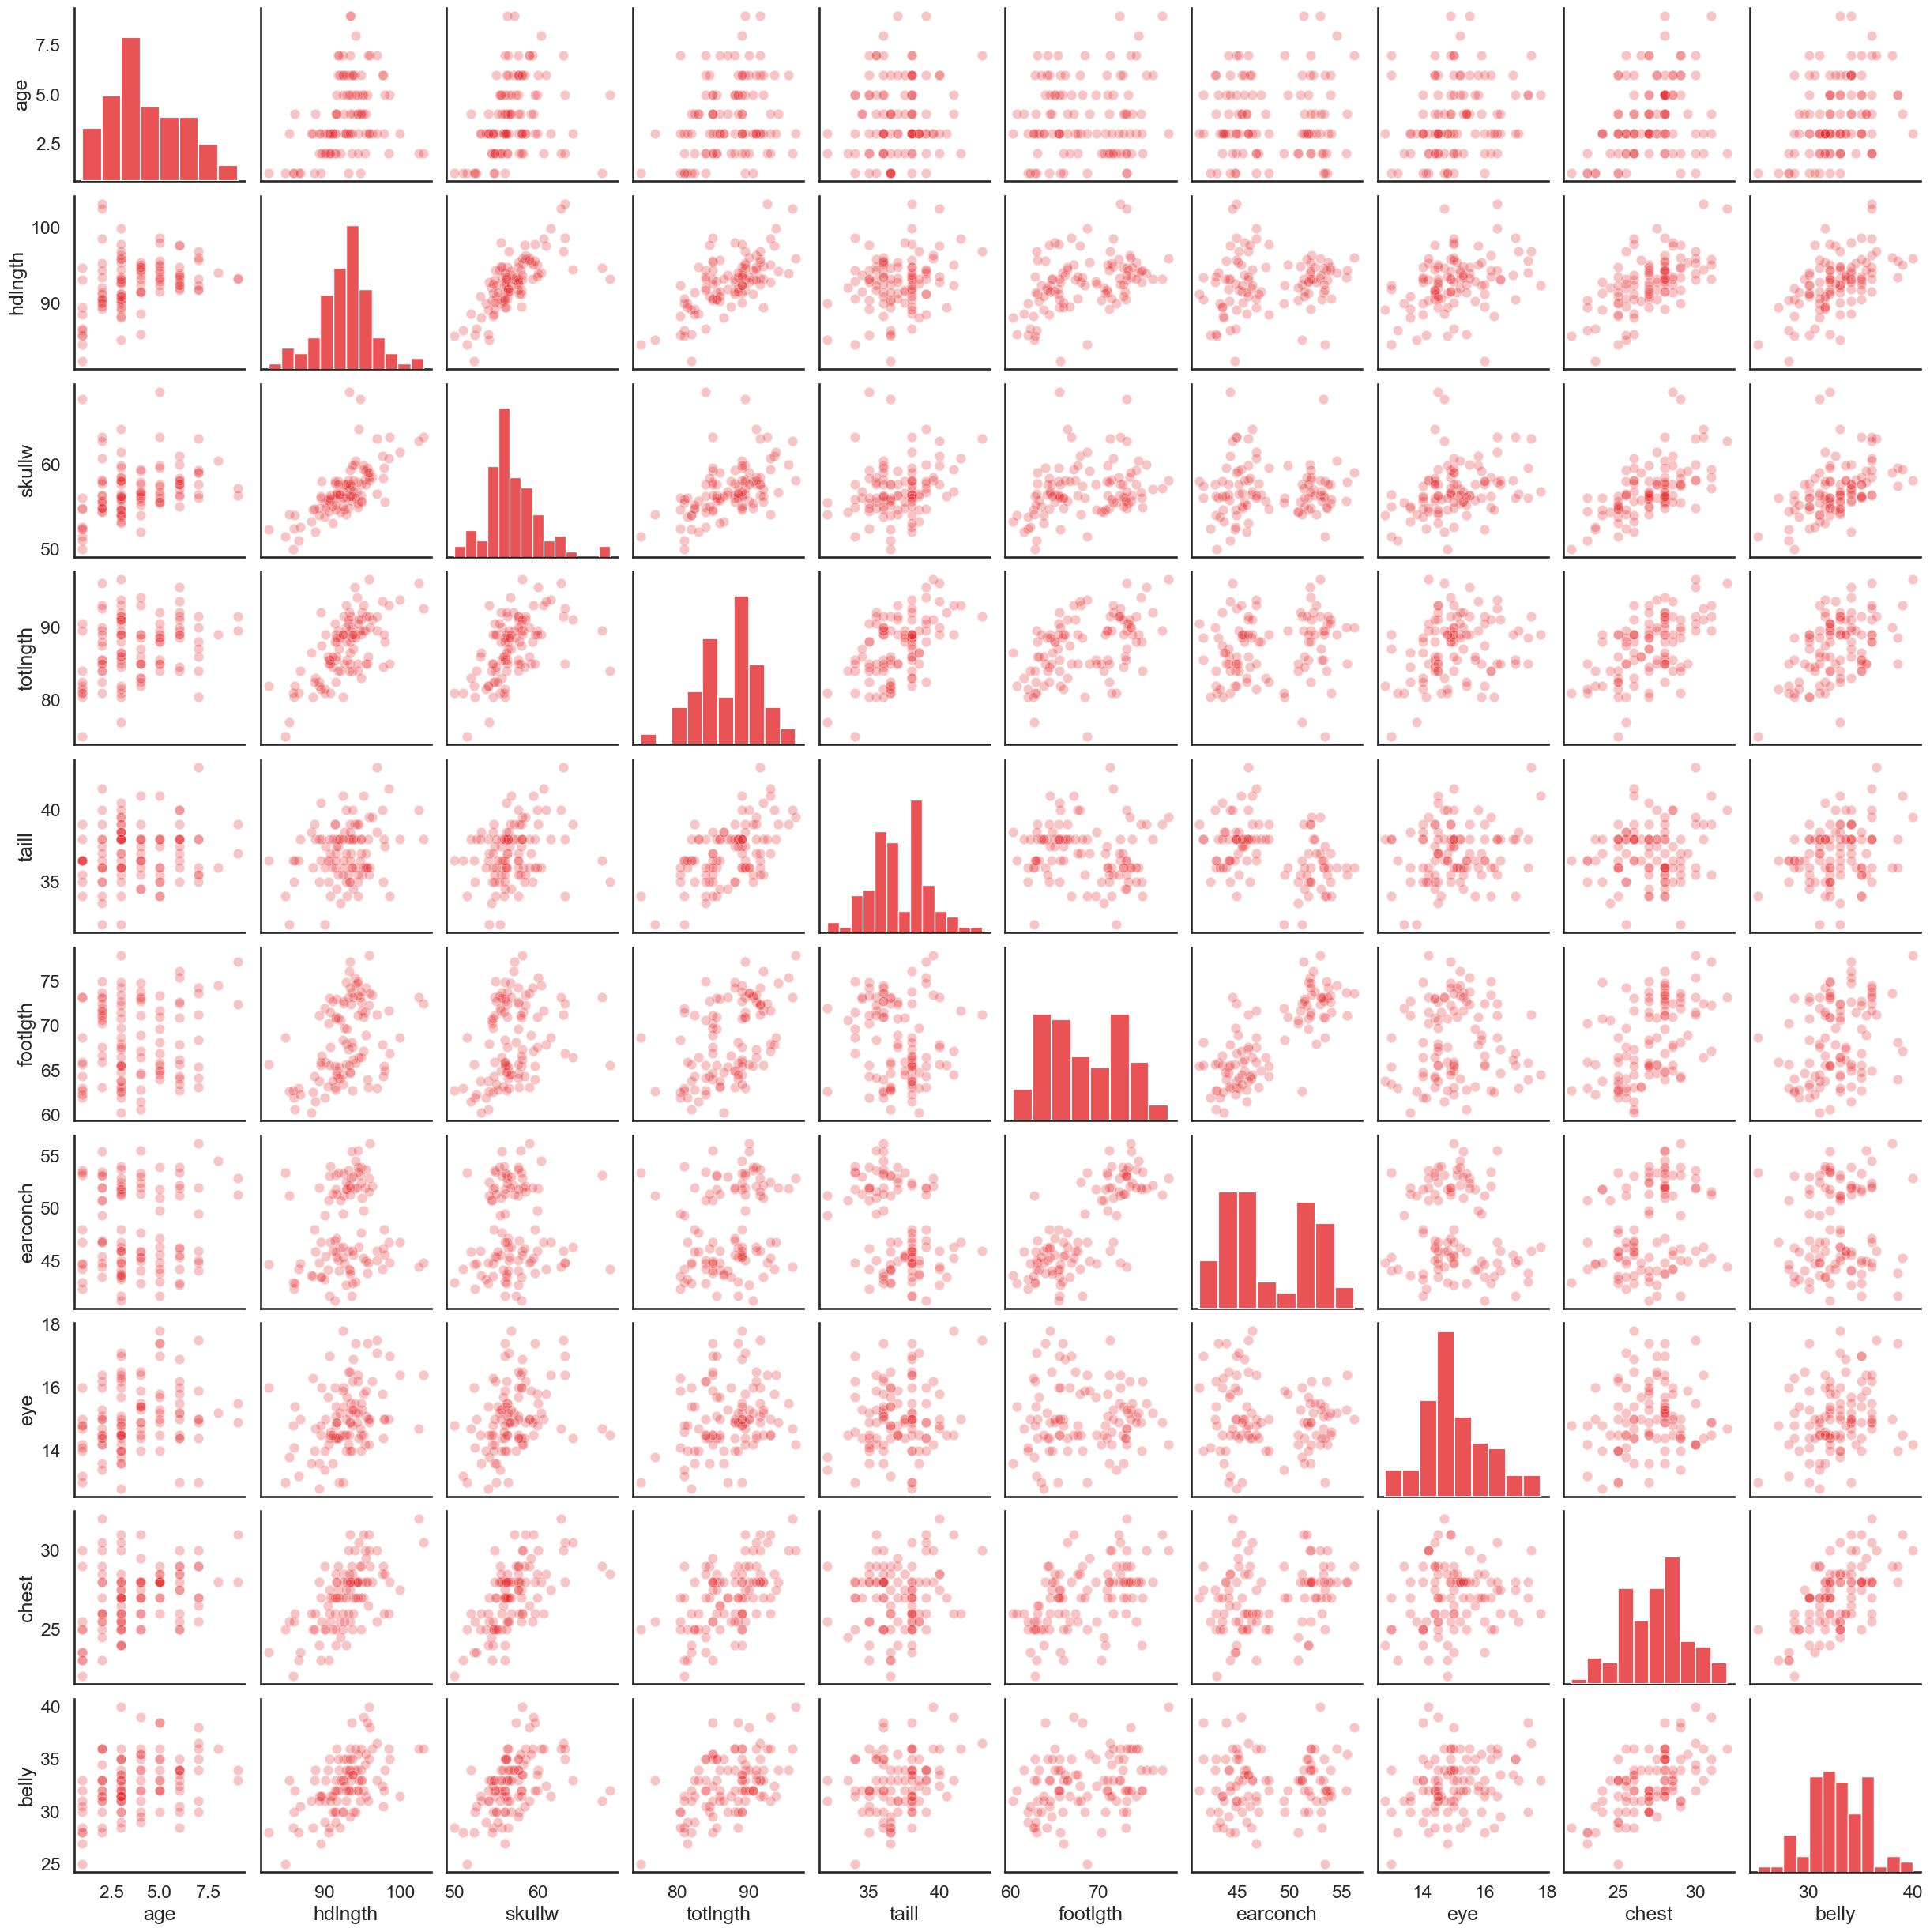

In [49]:
sns.pairplot(possum_data.drop(columns=['site','sex','case']), plot_kws=dict(alpha=0.25));
#pd.plotting.scatter_matrix(possum_data[['hdlngth','totlngth','taill','skullw']], alpha=0.2);


As expected, the total length is positively correlaed with the head length and tail length.

Now let's check for missing values in the dataset.

In [4]:
possum_data.isnull().sum()


case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

#### Handling missing data
We observe missing values in the age and footlength columns. Different approaches can be taken to address this issue, including [imputation for missing values](https://scikit-learn.org/stable/modules/impute.html). However, due to the small number of rows affected, we will simply remove those rows.

In [5]:
possum_data = possum_data.dropna()


#### Handling categorical features
We have several categorical columns in our dataset: 'sex','site' (the site number in which the possum was trapped),'Pop' (population). In order to include them in a machine-learning model, we need to transform them to numerical values. There are several approaches for this. Here, we will use **one hot encoding**.



https://datagy.io/wp-content/uploads/2022/01/One-Hot-Encoding-for-Scikit-Learn-in-Python-Explained-1024x576.png

In [46]:
print(f"Population values: {possum_data['Pop'].unique()}")
print(f"Sex values: {possum_data['sex'].unique()}")
print(f"Site values: {possum_data['site'].unique()}")

Population values: ['Vic' 'other']
Sex values: ['m' 'f']
Site values: [1 2 3 4 5 6 7]


In [7]:
possum_data_ = pd.get_dummies(possum_data ,prefix=['sex','site', 'Pop'], columns = ['sex','site','Pop'], drop_first=True)
possum_data_ .head()


,case,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,sex_m,site_2,site_3,site_4,site_5,site_6,site_7,Pop_other
0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,1,0,0,0,0,0,0,0
1,2,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,0,0,0,0,0,0,0,0
2,3,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,0,0,0,0,0,0,0,0
3,4,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,0,0,0,0,0,0,0,0
4,5,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,0,0,0,0,0,0,0,0


### Training set and testing set

While experimenting with any learning algorithm, it is important not to test the prediction of an estimator on the data used to fit the estimator as this would not be evaluating the performance of the estimator on new data. This is why datasets are often split into train and test data.

Split the dataset to train and test data using a random permutation - this is easily done with functions from the model_selection module, which has many methods to split datasets. We'll use a very simple one, train_test_split which just splits that data by sampling a fraction of the rows to the training set and the rest to the test set (without replacement).

Now let's split our data to train and test, using the `train_test_split` function.

In [83]:
X = possum_data_.drop(columns = ['case','chest']) #remove our target variable and the row index 
y = possum_data_['chest']
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2, random_state = 30)


Let's start with a linear regression model.

In [84]:
lm = LinearRegression()
lm.fit(x_train,y_train)
lm_train_score = lm.score(x_train,y_train)
lm_test_score = lm.score(x_test,y_test)
print(f"train score = {round(lm_train_score,2)}, test score = {round(lm_test_score,2)}")



train score = 0.68, test score = 0.16


## Regularized linear models:
The training score is much higher than the test score.
We clearly have overfitting here. One way to deal with overfitting is to use **regularization**.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Regularization.svg/500px-Regularization.svg.png" width="300"/>


Generally, in a linear model, we aim to minimize the residuals-sum-of-squares (RSS)

$\sum_{i=1}^{n}(y-y_{h})^2$ , where $y_{h}$ the model's prediction.

To avoid overfitting, in regularized linear models we add a **penalty term**, which is controled by a parameter called $\lambda$. Larger values of $\lambda$ generally result in stronger regularization.


##### Lasso regression (L1 regularization): 

Leads to *sparse* models, by adding a penalty based on the absolute values of the coefficients.

In the [Lasso model](https://en.wikipedia.org/wiki/Lasso_(statistics)) the loss function is given by:
$\sum_{i=1}^{n}(y-y_{h})^2+\lambda\sum_{i=1}^{q}\theta_{i}$


##### Ridge regression (L2 regularization): 

Encourages small, equally distributed coefficients based on a the square of the coefficients.

In the [Ridge model](https://en.wikipedia.org/wiki/Ridge_regression) model,  the loss function is given by: $\sum_{i=1}^{n}(y-y_{h})^2+\lambda\sum_{i=1}^{q}\theta_{i}^2$





In [85]:
lm1 = linear_model.Lasso()
lm1.fit(x_train,y_train)
lm1_train_score = lm1.score(x_train,y_train)
lm1_test_score = lm1.score(x_test,y_test)
print(f"train score = {round(lm1_train_score,2)}, test score = {round(lm1_test_score,2)}")


train score = 0.59, test score = 0.43


Due to the regularization, the Lasso model obtained a lower training score but a higher test score than the standard linear model!!


### KNN regression model

To predict the target of a new sample, simply find the K nearest data points to that sample in the training-set and average their target values.

Let's use a k-nearest neighbors model to do regression. In this case the predicted value is a weighted average of the neighbors.

Lets run the regression and print the model score.


In [86]:
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
y_hat = knn.predict(x_test)
knn_train_score = knn.score(x_train, y_train)
knn_test_score = knn.score(x_test, y_test)
print(f"train score = {round(knn_train_score,2)}, test score = {round(knn_test_score,2)}")

train score = 0.59, test score = 0.26


### Decision tree model:


In [112]:
from sklearn import tree

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(x_train, y_train)
tree_model_train_score = tree_model.score(x_train, y_train)
tree_model_test_score = tree_model.score(x_test, y_test)
print(f"train score = {round(tree_model_train_score,2)}, test score = {round(tree_model_test_score,2)}")


train score = 1.0, test score = -0.69


This clearly indicates an instance of **overfitting**. When using a single tree for prediction, the model is prone to overfitting. A more effective alternative involves utilizing a Random Forest regressor, which utilizes numerous trees for prediction, thereby effectively minimizing prediction variance.

Hyperparameters of the random forest model:


<img src="https://cdn.corporatefinanceinstitute.com/assets/random-forest.png" width="500"/>

In [105]:

rf_model = RandomForestRegressor(random_state=0, max_depth = 2)
rf_model.fit(x_train, y_train)
rf_model_train_score = rf_model.score(x_train, y_train)
rf_model_test_score = rf_model.score(x_test, y_test)
print(f"train score = {round(rf_model_train_score,2)}, test score = {round(rf_model_test_score,2)}")

train score = 0.67, test score = 0.34


### Hyper-parameters tuning using cross validation

So far we used the default hyperparameters of each model. Should we use the test set in order to tune the model hyperparameters? No! this would result in *overfitting on the test set*. We should not use the test-set for fine-tuning the model.

Instead, we can use a very common approach called **cross validation**.

We divide the training set into *n* folds. During each iteration, the model is trained on *n*-1 folds and evaluated on the remaining fold. The average score calculated over these iterations provides us with an estimation of the model's predictive performance on new, unseen data. This process, known as cross-validation, allows for a robust assessment of the model's generalization capabilities.


<img src="https://www.sharpsightlabs.com/wp-content/uploads/2024/02/5-fold-cross-validation_SIMPLE-EXAMPLE_v2.png" width="500"/>

For example, let's obtain the cross validation score for the random forest model using 5 folds:

In [111]:
cv_scores = cross_val_score(rf_model, x_train, y_train, cv = 5)
print(f"CV scores on each fold: {scores}")
print(f'Mean CV score = {round(np.mean(scores),2)}')

CV scores on each fold: [0.34482287 0.3217511  0.60690897 0.27052187 0.22518302]
Mean CV score = 0.35


In order to find the best hyperparameters for this model,
